In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, log_loss, recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load data csv
data = pd.read_csv("dataset HR analytics.csv")

data.tail().T

,282,283,284,285,286
Employee_Name,Yusril Firza,Yusril Iqbal,Zahrah,Zharfan Nugraha Permadi,Zia Ulhafidz Aldiansyah
EmpID,10283,10284,10285,10286,10287
MarriedID,Not married,Married,Not married,Married,Not married
MaritalStatusID,Single,Widowed,Single,Married,Single
GenderID,M,F,M,M,F
EmpStatusID,TKP/ Outsource,TKP/ Outsource,TKP/ Outsource,TKP/ Outsource,TKP/ Outsource
RoleID,Back End Developer,Back End Developer,Front End Developer,Back End Developer,Front End Developer
LevelID,Middle,Junior,Junior,Junior,Senior
PerfScoreID,Fully meets,Average,Exceed,Exceed,Special treatment
Tribe,EDU,LGT,EDU,EDU,FIN


# Data Preparation
---

In [3]:
data['EmploymentStatus'].value_counts()

Active                    194
Voluntarily Terminated     79
Terminated for Cause       14
Name: EmploymentStatus, dtype: int64

In [4]:
# Membuat data Duration dan Age

data['DateofTermination_v1'] = pd.to_datetime(data['DateofTermination_v1'], format='%m/%d/%Y')
data['DOB'] = pd.to_datetime(data['DOB'], format='%m/%d/%Y')
data['DateofHire'] = pd.to_datetime(data['DateofHire'], format='%m/%d/%Y')

data['Duration'] = data.apply(lambda x: relativedelta(x['DateofTermination_v1'], x['DateofHire']).years, axis = 1)
data['Age'] = data.apply(lambda x: relativedelta(x['DateofTermination_v1'], x['DOB']).years, axis = 1)

In [5]:
# Memilih variables yang akan dijadikan feature
variables = ['LevelID', 'PerfScoreID', 
             'EngagementSurvey', 
             'EmpSatisfaction', 
             'SpecialProjectsCount',
             'DaysLateLast30', 
             'Absences', 
             'Age', 
             'Duration', 
             'EmploymentStatus']
df = data[variables].copy()
df.columns = ['Churn' if i == 'EmploymentStatus' else i for i in variables]

# Mendefinisikan churn
df['Churn'] = df['Churn'].apply(lambda x : 0 if x == 'Active' else 1)
df['Churn'].value_counts()

0    194
1     93
Name: Churn, dtype: int64

In [6]:
# Cek proporsi variabel respon
df['Churn'].value_counts(normalize=True)

0    0.675958
1    0.324042
Name: Churn, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LevelID               287 non-null    object 
 1   PerfScoreID           287 non-null    object 
 2   EngagementSurvey      287 non-null    float64
 3   EmpSatisfaction       287 non-null    int64  
 4   SpecialProjectsCount  287 non-null    int64  
 5   DaysLateLast30        287 non-null    int64  
 6   Absences              287 non-null    int64  
 7   Age                   287 non-null    int64  
 8   Duration              287 non-null    int64  
 9   Churn                 287 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 22.5+ KB


# Sample Splitting
---

In [8]:
response_variable = 'Churn'

# Split respon dan prediktor
y = df[response_variable]
X = df.drop(columns=[response_variable], axis=1)

print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (287,)
X shape : (287, 9)


In [9]:
# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (200, 9)
y train shape : (200,)
X test shape  : (87, 9)
y test shape  : (87,)


In [10]:
y_train.value_counts(normalize=True)

0    0.675
1    0.325
Name: Churn, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.678161
1    0.321839
Name: Churn, dtype: float64

In [12]:
X_train.reset_index()['index']

0       57
1       45
2      270
3      265
4       47
      ... 
195     37
196     39
197    199
198     28
199    174
Name: index, Length: 200, dtype: int64

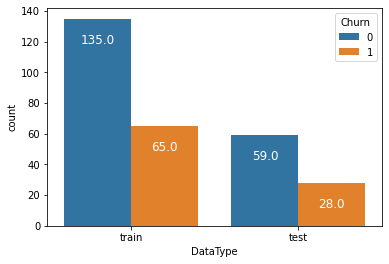

In [13]:
# proporsi data type

df.loc[df.reset_index()['index'].isin(X_train.reset_index()['index']), 'DataType'] = 'train'
df.loc[df.reset_index()['index'].isin(X_test.reset_index()['index']), 'DataType'] = 'test'

# Proporsi churn berdasarkan 'LevelID'
ax = sns.countplot(data = df, x = 'DataType', hue = 'Churn')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', 
                size=12)

<AxesSubplot:ylabel='Churn'>

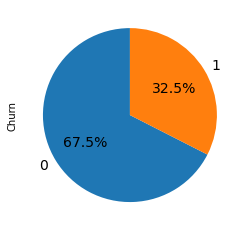

In [14]:
# proporsi churn pada train set

y_train.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=False, 
                                               legend = False, fontsize=14)

<AxesSubplot:ylabel='Churn'>

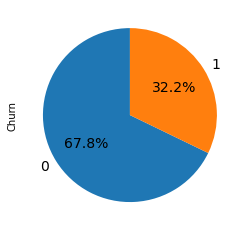

In [15]:
# proporsi churn pada test set

y_test.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=False, 
                                               legend = False, fontsize=14)

# Data Understanding
---

In [16]:
# Concat X_train dan y_train sebagai data_train
data_train = pd.concat((X_train, y_train), axis=1)

print('Train data shape:', data_train.shape)
data_train.head().T

Train data shape: (200, 10)


,57,45,270,265,47
LevelID,Junior,Middle,Senior,Senior,Junior
PerfScoreID,Exceed,Exceed,Exceed,Average,Average
EngagementSurvey,3.04,3.0,4.1,4.1,3.58
EmpSatisfaction,3,5,4,4,5
SpecialProjectsCount,6,0,0,0,0
DaysLateLast30,0,0,0,0,0
Absences,2,17,18,16,3
Age,34,51,32,44,33
Duration,6,9,10,4,9
Churn,0,0,0,1,0


## Check for Missing Values

---

In [17]:
# Cek missing values
pd.DataFrame(data_train.isna().sum()).rename(columns = {0: 'missing value'})

,missing value
LevelID,0
PerfScoreID,0
EngagementSurvey,0
EmpSatisfaction,0
SpecialProjectsCount,0
DaysLateLast30,0
Absences,0
Age,0
Duration,0
Churn,0


In [18]:
# Cek tipe data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 57 to 174
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LevelID               200 non-null    object 
 1   PerfScoreID           200 non-null    object 
 2   EngagementSurvey      200 non-null    float64
 3   EmpSatisfaction       200 non-null    int64  
 4   SpecialProjectsCount  200 non-null    int64  
 5   DaysLateLast30        200 non-null    int64  
 6   Absences              200 non-null    int64  
 7   Age                   200 non-null    int64  
 8   Duration              200 non-null    int64  
 9   Churn                 200 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 17.2+ KB


## Exploratory Data Analysis
--- 

In [19]:
cat_ = ['LevelID', 'PerfScoreID', 'EmpSatisfaction']
num_ = ['EngagementSurvey', 'SpecialProjectsCount', 'DaysLateLast30', 
        'Absences', 'Age', 'Duration']

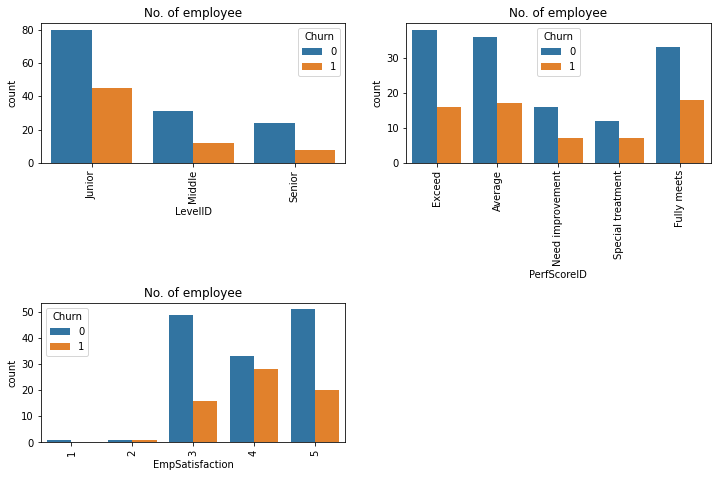

In [20]:
fig=plt.subplots(figsize=(12,18))
for i, j in enumerate(cat_):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data=data_train, hue='Churn')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

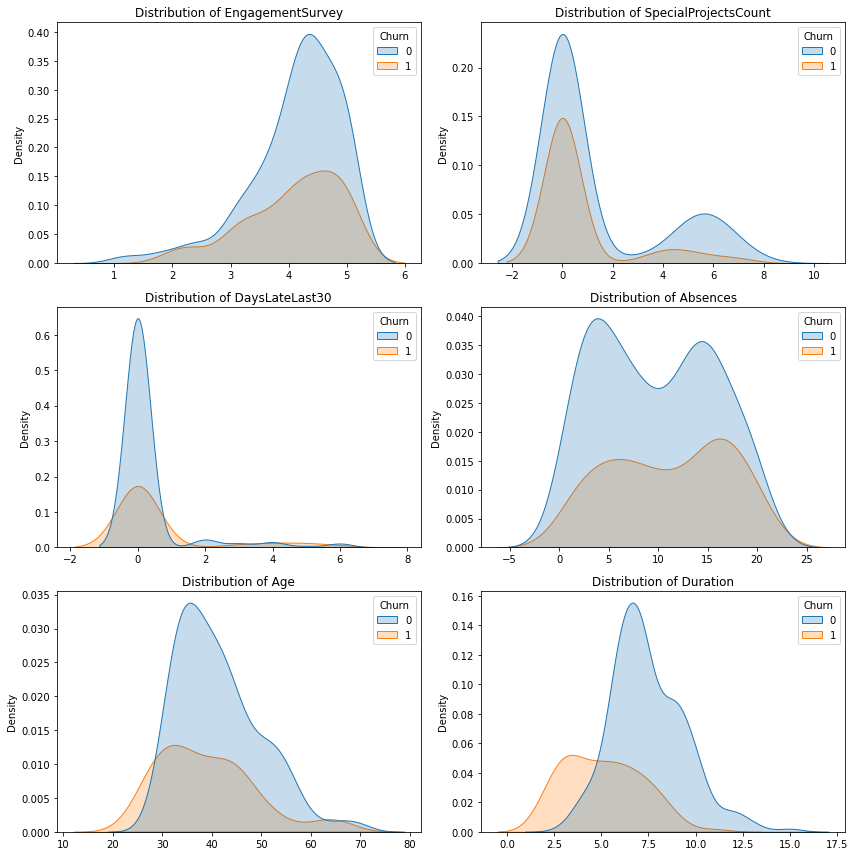

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = num_

for col, ax in zip(cols, axes):
    data = df[[col, 'Churn']]  # select the data
    sns.kdeplot(data=data, x=col, hue='Churn', fill=True, ax=ax)
    ax.set(title=f'Distribution of {col}', xlabel=None)
    
fig.tight_layout()
plt.show()

# Data Preprocessing
---

## Make Dummies
---

Berdasarkan EDA, ada 3 prediktor kategorik yaitu `LevelID`, `PerfScoreID` , dan `EmpSatisfaction`. Prediktor `EmpSatisfaction` sudah menjadi ordinal dalam bentuk angka. Sedangkan prediktor `LevelID` dan  `PerfScoreID` harus dilakukan transformasi. Kedua prediktor tersebut ordinal. Sehingga, transformasi kategorik menjadi numerik diurutkan dari level terendah hingga level tertinggi.

In [22]:
# Dict LevelID
level = {
    "Junior" : 1,
    "Middle": 2, 
    "Senior": 3
}

# Dict PerfScoreID
perf = {
    "Special treatment" : 1,
    "Need improvement": 2,
    "Average": 3,
    "Fully meets": 4,
    "Exceed": 5
}
 
# Transformasi kategorik menjadi numerik pada data Train
X_train['LevelID'] = X_train['LevelID'].map(level)
X_train['PerfScoreID'] = X_train['PerfScoreID'].map(perf)

# Transformasi kategorik menjadi numerik pada data Test
X_test['LevelID'] = X_test['LevelID'].map(level)
X_test['PerfScoreID'] = X_test['PerfScoreID'].map(perf)

## Scaling Data
---

In [23]:
# Buat scaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [24]:
# Convert X_train & X_test
def scaler_transform(data, scaler):
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled)
    data_scaled.columns = data.columns
    data_scaled.index = data.index

    return data_scaled

In [25]:
X_train_scaled = scaler_transform(data = X_train,
                                  scaler = scaler)
X_train_scaled.head()

,LevelID,PerfScoreID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Duration
57,-0.709388,1.197546,-1.424547,-1.137626,2.079111,-0.291745,-1.393525,-0.708183,-0.243537
45,0.616570,1.197546,-1.475845,1.149059,-0.519778,-0.291745,1.117331,1.306731,1.097035
270,1.942528,1.197546,-0.065149,0.005717,-0.519778,-0.291745,1.284721,-0.945232,1.543892
265,1.942528,-0.388607,-0.065149,0.005717,-0.519778,-0.291745,0.949940,0.477061,-1.137252
47,-0.709388,-0.388607,-0.732023,1.149059,-0.519778,-0.291745,-1.226135,-0.826707,1.097035


In [26]:
X_train_scaled.describe()

,LevelID,PerfScoreID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Duration
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,9.214851e-17,-1.698641e-16,-3.008704e-16,-1.784163e-16,3.663736e-17,5.884182e-17,9.325873e-17,-1.798561e-16,3.302913e-17
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-7.093875e-01,-1.974761e+00,-3.784258e+00,-3.424311e+00,-5.197777e-01,-2.917448e-01,-1.560915e+00,-1.893427e+00,-2.030967e+00
25%,-7.093875e-01,-3.886075e-01,-5.396556e-01,-1.137626e+00,-5.197777e-01,-2.917448e-01,-9.332014e-01,-7.081831e-01,-6.903946e-01
50%,-7.093875e-01,4.044690e-01,1.913418e-01,5.716713e-03,-5.197777e-01,-2.917448e-01,1.129885e-01,-2.340856e-01,-2.435373e-01
75%,6.165704e-01,1.197546e+00,7.524143e-01,1.149059e+00,-5.197777e-01,-2.917448e-01,9.499405e-01,5.955850e-01,6.501775e-01
max,1.942528e+00,1.197546e+00,1.089058e+00,1.149059e+00,2.945407e+00,5.265300e+00,1.619502e+00,3.558694e+00,3.778179e+00


In [27]:
X_test_scaled = scaler_transform(data = X_test,
                                 scaler = scaler)
X_test_scaled.head()

,LevelID,PerfScoreID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Duration
185,-0.709388,1.197546,0.037448,0.005717,-0.519778,-0.291745,1.117331,1.188207,-0.243537
27,1.942528,-0.388607,-0.975689,-1.137626,-0.519778,-0.291745,0.615160,0.714109,-2.030967
48,-0.709388,0.404469,0.704322,-1.137626,2.079111,-0.291745,-1.393525,-0.589659,0.650177
71,-0.709388,-0.388607,0.191342,0.005717,-0.519778,-0.291745,-1.560915,-0.234086,0.203320
285,-0.709388,1.197546,0.576077,-1.137626,1.212815,-0.291745,-0.221792,-0.471134,0.203320


# Model Fitting
---

In [28]:
# Buat weight class
n_samples = len(y_train)
n_classes = len(y_train.value_counts())
n_samples_j = y_train.value_counts()

class_weight = n_samples / (n_classes * n_samples_j)
class_weight

# Kita kasih weight yang lebih besar untuk kelas 1

0    0.740741
1    1.538462
Name: Churn, dtype: float64

In [29]:
# Buat objek
logreg_ori = LogisticRegression(penalty = 'none',
                                random_state = 123)

# Fit model
logreg_ori.fit(X_train_scaled, y_train)

LogisticRegression(penalty='none', random_state=123)

In [30]:
# Buat objek
logreg_weight = LogisticRegression(penalty = 'none',
                                   class_weight = dict(class_weight),
                                   random_state = 123)

# Fit model
logreg_weight.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 0.7407407407407407, 1: 1.5384615384615385},
                   penalty='none', random_state=123)

In [31]:
# Buat objek
logreg = LogisticRegression(class_weight = dict(class_weight),
                            solver = "liblinear",
                            random_state = 123)

# Lakukan eksperimentasi
search_params = {"penalty": ["l1", "l2"],
                 "C": np.logspace(-5, 5, 20)}

logreg_cv = GridSearchCV(estimator = logreg,
                         param_grid = search_params,
                         cv = 5)

# Lakukan Fitting Data
logreg_cv.fit(X = X_train_scaled,
              y = y_train)

# Buat best model
logreg_cv = LogisticRegression(penalty = logreg_cv.best_params_["penalty"],
                            C = logreg_cv.best_params_["C"],
                            class_weight = dict(class_weight),
                            solver = "liblinear",
                            random_state = 123)

# Fit model
logreg_cv.fit(X_train_scaled, y_train)

LogisticRegression(C=20.6913808111479,
                   class_weight={0: 0.7407407407407407, 1: 1.5384615384615385},
                   random_state=123, solver='liblinear')

## Model Evaluation
---

In [32]:
def metrics(y_test, y_predict, y_predict_proba, model):
    """
    performa metrics yang digunakan yaitu accuracy, precision, recall, avg precision-recall, 
    ROC AUC, GIni coef, dan log loss
    """

    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    log_loss_score = log_loss(y_test, y_predict_proba)
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    avg_precision_recall = average_precision_score(y_test, y_predict_proba)

    matrix = confusion_matrix(y_test, y_predict)
    metrics = pd.DataFrame(matrix.ravel()).transpose()
    confusion_matrix_dict = {0: "True Negative", 1: "False Positive", 2: "False Negative", 3: "True Positive"}
    metrics.rename(columns = confusion_matrix_dict, inplace = True)
    metrics.insert(0, "Metrics", model)
    metrics["Accuracy"] = accuracy
    metrics["Precision"] = precision
    metrics["Recall"] = recall
    metrics["Average precision-recall score"] = avg_precision_recall
    metrics["ROC AUC"] = roc_auc
    metrics["Gini coefficient"] = 2*roc_auc-1
    metrics["Log Loss"] = log_loss_score
    
    return metrics

In [33]:
# performance metrics untuk masing-masing treatment
original_metrics = metrics(y_train, 
                           logreg_ori.predict(X_train_scaled), 
                           logreg_ori.predict_proba(X_train_scaled)[:,1], 
                           "Train: Original")
weight_metrics = metrics(y_train, 
                           logreg_weight.predict(X_train_scaled), 
                           logreg_weight.predict_proba(X_train_scaled)[:,1], 
                         "Train: Weighted/")
gridscv_metrics = metrics(y_train, 
                           logreg_cv.predict(X_train_scaled), 
                           logreg_cv.predict_proba(X_train_scaled)[:,1], 
                          "Train: GridSearchCV")

metrics_train = [original_metrics, weight_metrics, gridscv_metrics]

train_metrics = pd.concat(metrics_train)
train_metrics = train_metrics.reset_index(drop = True).T
train_metrics.columns = list(train_metrics.iloc[0])
train_metrics = train_metrics[1:]
train_metrics

,Train: Original,Train: Weighted/,Train: GridSearchCV
True Negative,124,107,107
False Positive,11,28,28
False Negative,24,15,15
True Positive,41,50,50
Accuracy,0.825,0.785,0.785
Precision,0.788462,0.641026,0.641026
Recall,0.630769,0.769231,0.769231
Average precision-recall score,0.810123,0.801898,0.801898
ROC AUC,0.862564,0.86188,0.86188
Gini coefficient,0.725128,0.723761,0.723761


In [34]:
# performance metrics untuk masing-masing treatment
original_metrics = metrics(y_test, 
                           logreg_ori.predict(X_test_scaled), 
                           logreg_ori.predict_proba(X_test_scaled)[:,1], 
                           "Test: Original")
weight_metrics = metrics(y_test, 
                           logreg_weight.predict(X_test_scaled), 
                           logreg_weight.predict_proba(X_test_scaled)[:,1], 
                         "Test: Weighted")
gridscv_metrics = metrics(y_test, 
                           logreg_cv.predict(X_test_scaled), 
                           logreg_cv.predict_proba(X_test_scaled)[:,1], 
                          "Test: GridSearchCV")

metrics_test = [original_metrics, weight_metrics, gridscv_metrics]

test_metrics = pd.concat(metrics_test)
test_metrics = test_metrics.reset_index(drop = True).T
test_metrics.columns = list(test_metrics.iloc[0])
test_metrics = test_metrics[1:]
test_metrics

,Test: Original,Test: Weighted,Test: GridSearchCV
True Negative,53,49,50
False Positive,6,10,9
False Negative,13,12,12
True Positive,15,16,16
Accuracy,0.781609,0.747126,0.758621
Precision,0.714286,0.615385,0.64
Recall,0.535714,0.571429,0.571429
Average precision-recall score,0.74033,0.72344,0.72344
ROC AUC,0.810533,0.802058,0.802058
Gini coefficient,0.621065,0.604116,0.604116


# Model Selection
---

In [35]:
def kfold_split(X, k=5, random_state=42):
    """
    Function to split sample with validation set approach.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    k : int, default = 5
        Number of folds.

    random_state : int
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    train_ind_list : list
        Contains data index of train set.

    valid_ind_list : list
        Contains data index of validation set.
    """
    # Extract sample size
    n_samples, _ = X.shape

    # Set random state
    np.random.seed(random_state)

    # # Randomize index
    random_ind = np.random.choice(n_samples,
                                  size = n_samples,
                                  replace = False)

    # Calculate size of each fold
    fold_sizes = np.ones(k, dtype=int) * (n_samples//k)
    fold_sizes[:n_samples%k] += 1

    # Define initial list for each train and valid index
    train_ind_list = []
    valid_ind_list = []

    # Split sample
    current_ind = 0
    for size in fold_sizes:
        # Define index
        start_ind = current_ind
        end_ind = current_ind + size

        # Slice valid set
        # One fold for valid set, the remaining for train set
        valid_ind = random_ind[start_ind:end_ind]
        train_ind = np.concatenate((random_ind[:start_ind],
                                    random_ind[end_ind:]))

        # Update current index
        current_ind = end_ind

        # Append train and valid index in list
        train_ind_list.append(train_ind)
        valid_ind_list.append(valid_ind)

    return train_ind_list, valid_ind_list

In [36]:
def cross_validate(X, y, method, cv, random_state=42):
    """
    Function to evaluate AUC by cross-validation method.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    method : cross-validation splitter
        Cross-validation method.

    cv : int
        Number of folds for k-Fold CV.

    random_state : int, default=42
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    score : float
        The average ROC AUC score.
    """
    # Split train and valid set based on CV method
    if method == "validation_set":
        train_ind_list, valid_ind_list = validation_set_split(X = X,
                                                              random_state = random_state)
    elif method == "loocv":
        train_ind_list, valid_ind_list = loocv_split(X = X)
    elif method == "kfold":
        train_ind_list, valid_ind_list = kfold_split(X = X,
                                                     k = cv,
                                                     random_state = random_state)

    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize AUC score list for each valid set
    score_list = []

    for i in range(n_split):
        # Extract data from index
        X_train = X[train_ind_list[i]]
        y_train = y[train_ind_list[i]]
        X_valid = X[valid_ind_list[i]]
        y_valid = y[valid_ind_list[i]]

        # Fitting model
        model = LogisticRegression(penalty = 'none',
                                   class_weight = dict(class_weight),
                                   random_state = 123)
        model.fit(X_train, y_train)

        # Calculate success probability
        pred_train = model.predict_proba(X_train)
        pred_valid = model.predict_proba(X_valid)

        y_pred_train = pred_train[:,1]
        y_pred_valid = pred_valid[:,1]
        
        roc_auc_valid = roc_auc_score(y_valid, y_pred_valid)
        
        # Append AUC score in list
        score_list.append(roc_auc_valid)

    # Calculate CV Score
    score = np.mean(score_list)

    return score

In [37]:
def forward(X, y, predictors, method, cv=5, random_state=42):
    """
    Function to perform best subset selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
        Index of predictors

    method : cross-validation splitter
        Cross-validation method.

    cv : int, default=5
        Number of folds for k-Fold CV.

    random_state : int, default=42
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
        Summary of predictors and its AUC score for each possible combination.

    best_model : {array-like} of shape (2, )
        Best model of models with the smallest AUC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Cross validate to get CV Score
        score_ = cross_validate(X = X_,
                                y = y_,
                                method = method,
                                cv = cv,
                                random_state = random_state)

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                            "ROC AUC": score_list})

    # Choose the best model
    best_model = models.loc[models["ROC AUC"].argmax()]

    return models, best_model

In [38]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train_scaled.to_numpy(),
                        y = y_train.to_numpy(),
                        method = 'kfold',
                        cv = 5,
                        random_state = 42)

# Mendefinisakan tabel untuk best model untuk setiap k prediktor
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "ROC AUC": [score_]})

forward_models

,Predictors,ROC AUC
0,[],0.845842


In [39]:
# Definisikan list prediktor
predictors = []
n_predictors = X_train.shape[1]

# Teknik forward selection untuk k=1,...,9 prediktor
for k in range(n_predictors):
    _, best_model = forward(X = X_train_scaled.to_numpy(),
                            y = y_train.to_numpy(),
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 42)

    # Tabulasi best model pada masing-masing k prediktor 
    forward_models.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [40]:
# Best model pada masing-masing k prediktor
forward_models

,Predictors,ROC AUC
0,[],0.845842
1,[8],0.770881
2,"[8, 4]",0.821808
3,"[8, 4, 5]",0.839900
4,"[8, 4, 5, 6]",0.852738
5,"[8, 4, 5, 6, 0]",0.858617
6,"[8, 4, 5, 6, 0, 3]",0.861094
7,"[8, 4, 5, 6, 0, 3, 1]",0.854141
8,"[8, 4, 5, 6, 0, 3, 1, 7]",0.853322
9,"[8, 4, 5, 6, 0, 3, 1, 7, 2]",0.845842


In [41]:
# Best AUC score
best_idx = forward_models['ROC AUC'].argmax()
best_AUC = forward_models['ROC AUC'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]
best_preds = data_train.columns[best_predictors].tolist()

print('Best index            :', best_idx)
print('Best ROC AUC          :', best_AUC)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(data_train.columns[best_predictors].tolist())

Best index            : 6
Best ROC AUC          : 0.8610935208161015
Best predictors (idx) : [8, 4, 5, 6, 0, 3]
Best predictors       :
['Duration', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'LevelID', 'EmpSatisfaction']


In [42]:
# Best predictors
X_train_best = X_train_scaled[best_preds]

# Buat objek
logreg_best = LogisticRegression(penalty = 'none',
                                   class_weight = dict(class_weight),
                                   random_state = 123)

# Fit model
logreg_best.fit(X_train_best, y_train)

LogisticRegression(class_weight={0: 0.7407407407407407, 1: 1.5384615384615385},
                   penalty='none', random_state=123)

In [43]:
# performance metrics untuk masing-masing treatment
train_metrics = metrics(y_train, 
                           logreg_best.predict(X_train_scaled[best_preds]), 
                           logreg_best.predict_proba(X_train_scaled[best_preds])[:,1], 
                          "Train")

test_metrics = metrics(y_test, 
                           logreg_best.predict(X_test_scaled[best_preds]), 
                           logreg_best.predict_proba(X_test_scaled[best_preds])[:,1], 
                          "Test")

metrics_data = [train_metrics, test_metrics]

metrics_ = pd.concat(metrics_data)
metrics_ = metrics_.reset_index(drop = True).T
metrics_.columns = list(metrics_.iloc[0])
metrics_ = metrics_[1:]
metrics_

,Train,Test
True Negative,107,46
False Positive,28,13
False Negative,14,11
True Positive,51,17
Accuracy,0.79,0.724138
Precision,0.64557,0.566667
Recall,0.784615,0.607143
Average precision-recall score,0.788346,0.727852
ROC AUC,0.855157,0.812954
Gini coefficient,0.710313,0.625908


<AxesSubplot:ylabel='Count'>

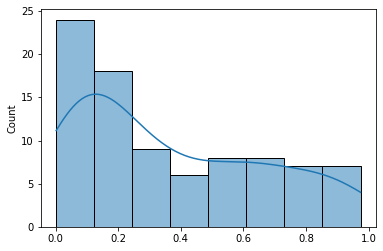

In [44]:
# Distribusi predicted probability
sns.histplot(x = logreg_best.predict_proba(X_test_scaled[best_preds])[:,1],
             kde = True)

# Interpret the Best Model Parameters
---

In [45]:
# Intercept linear regression
logreg_cv.intercept_

array([-0.4790876])

In [46]:
# Koefisien logistic regression
logreg_best.coef_[0]

array([-1.65491028, -0.87848892,  0.35767703,  0.34349766, -0.38210034,
        0.12071578])

In [47]:
logreg_best.feature_names_in_

array(['Duration', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'LevelID', 'EmpSatisfaction'], dtype=object)

In [48]:
dfcoef = pd.DataFrame()
feats_ = ['Constant']
feats_.extend(logreg_best.feature_names_in_)

score_ = list(logreg_best.intercept_)
score_.extend(logreg_best.coef_[0])

dfcoef['features'] = feats_
dfcoef['weights'] = score_

dfcoef

,features,weights
0,Constant,-0.438380
1,Duration,-1.654910
2,SpecialProjectsCount,-0.878489
3,DaysLateLast30,0.357677
4,Absences,0.343498
5,LevelID,-0.382100
6,EmpSatisfaction,0.120716


# Summary
---

**Summary:**
- Best model didapat setelah melakukan model selection karena memiliki nilai recall yang lebih besar.
- Dengan forward selection, diperoleh best model dengan 6 predictors yaitu `Duration, SpecialProjectsCount, DaysLateLast30, Absences, LevelID, dan EmpSatisfaction`
- AUC pada training set original dan pembobotan hampir mirip, disebabkan  imbalanced data set 

In [49]:
dfcoef

,features,weights
0,Constant,-0.438380
1,Duration,-1.654910
2,SpecialProjectsCount,-0.878489
3,DaysLateLast30,0.357677
4,Absences,0.343498
5,LevelID,-0.382100
6,EmpSatisfaction,0.120716


- **Prediktor yang meningkatkan resign pegawai** :
    - `DaysLateLast30` 
    - `Absences`
    - `EmpSatisfaction`

- **Prediktor yang menurunkan resign pegawai** :
    - `Duration` 
    - `SpecialProjectsCount`
    - `LevelID`

# References
---


- https://medium.com/@roihatul.mahmudah/hr-dataset-a5963ebddfc9
- Daniel Jurafsky, James H. Martin. Speech and Language Processing.
- Garest James, Daniela Witten, Trevor Hastie, Robert Tibshirani. An Introduction to Statistical Learning
- Trevor Hastie, Robert Tibshirani, Jerome Friedman. The Elements of Statistical Learning